# Seq2Seq EqLearn -- First Attempt

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import math
import time
import sympy
from sympy import lambdify
from eq_learner.DatasetCreator import DatasetCreator
from eq_learner.processing import tokenization
from sympy import sin, Symbol, log, exp 
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader,Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchtext.datasets 
from torchtext.data import Field, BucketIterator
import matplotlib.pyplot as plt
#from eq_learner.processing import dataset

### Deterministic Results

In [2]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Generate Datasets
As a first experiment we will create a dataset with all the targets padded to same length. Additionally, we discard equation yielding too large values associated with the fixed support. This is to apply a scaling and have data from 0 tpo 1. 
Next stesps should create variable length output and batch them according to their length so that the amount of padding is minimized. See torchtext.dataset.

#### GPU as standard device

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Ckasses handling batches generation and train/validation split

In [4]:
class TensorDataset(Dataset):
    r"""Dataset wrapping tensors.

    Each sample will be retrieved by indexing tensors along the first dimension.

    Arguments:
        *tensors (Tensor): tensors that have the same size of the first dimension.
    """

    def __init__(self, *tensors):
        self.tensors = tensors

    def __getitem__(self, index):
        return tuple(tensor[index].cuda() for tensor in self.tensors)

    def __len__(self):
        return self.tensors[0].size(0)
    
def dataset_loader(train_dataset,test_dataset, batch_size = 1024, valid_size = 0.20):
    num_train = len(train_dataset)
    num_test_h = len(test_dataset)
    indices = list(range(num_train))
    test_idx_h = list(range(num_test_h))
    np.random.shuffle(test_idx_h)
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)


    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
        sampler=train_sampler, num_workers=0)
    valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
        sampler=valid_sampler, num_workers=0)
    test_loader_h = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
        shuffle=False, num_workers=0)
    return train_loader, valid_loader, test_loader_h, valid_idx, train_idx

sin(x)+sin(exp(2*x)+1)
[12  2  5  1  6  9  2  5  3  5 15  8  1  6  9 14  6 13]


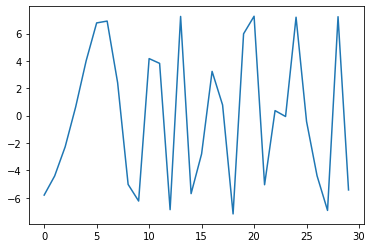

In [5]:
scale = True
scaler = MinMaxScaler()
x = Symbol('x')
basis_functions = [x,sin,log,exp]
support = np.arange(0.1,3.1,0.1)
fun_generator = DatasetCreator(basis_functions,max_linear_terms=1, max_binomial_terms=1,max_compositions=1,max_N_terms=1,division_on=False,  random_terms=True, constants_enabled = True, constant_intervals_ext=[(-10,1),(1,10)], constant_intervals_int = [(1,3)])
string, dictionary = fun_generator.generate_batch(support,1, X_noise=False, Y_noise=0)
print(tokenization.get_string(tokenization.pipeline(dictionary)[0]))
print(tokenization.pipeline(dictionary)[0])
plt.plot(string[0][1])

In [6]:
sympy.Symbol

sympy.core.symbol.Symbol

#### Equations sampling and numerical scaling
Need to test if it's better to normalize across time or across data

In [7]:
scale = True
scaler = MinMaxScaler()
x = Symbol('x')
basis_functions = [x,sin,log,exp]
support = np.arange(0.1,3.1,0.1)
fun_generator = DatasetCreator(basis_functions,max_linear_terms=1, max_binomial_terms=1,max_compositions=1,max_N_terms=0,division_on=False,  random_terms=True, constants_enabled = True, constant_intervals_ext=[(-3,1),(1,3)], constant_intervals_int = [(1,3)])
x_train = []
y_train = []
cnt = 0
cond = True
# while cond == True:
#     string, dictionary =  fun_generator.generate_batch(support,1, X_noise=False, Y_noise=0)
#     if np.all(string[0][1] == 0) == False:
#         if np.max(string[0][1])<1000 and np.min(string[0][1])>-1000 and tokenization.get_string(tokenization.pipeline(dictionary)[0])[-1] != '+': 
#             x_train.append(string[0][1])
#             y_train.append(torch.Tensor((tokenization.pipeline(dictionary)[0])))
# #             print(tokenization.get_string(tokenization.pipeline(dictionary)[0]))
#             cnt+=1
#             print(cnt)
#     if cnt == 500000:
#         cond = False
# scaler.fit(np.array(x_train).T)
# x_train_n = scaler.transform(np.array(x_train).T)
# x_train_n = torch.Tensor(x_train_n)
# l = [len(y) for y in y_train]
# q = np.max(l)
# y_train_p = torch.zeros(len(y_train),q)
# for i,y in enumerate(y_train):
#     y_train_p[i,:] = torch.cat([y,torch.zeros(q-y.shape[0])])
# train_data = TensorDataset(x_train_n.T,y_train_p.long())

x_test = []
y_test = []
cnt = 0
cond = True
while cond == True:
    string, dictionary =  fun_generator.generate_batch(support,1, X_noise=False, Y_noise=0)
    if np.all(string[0][1] == 0) == False:
        if np.max(string[0][1])<1000 and np.min(string[0][1])>-1000 and tokenization.get_string(tokenization.pipeline(dictionary)[0])[-1] != '+': 
            x_test.append(string[0][1])
            y_test.append(torch.Tensor((tokenization.pipeline(dictionary)[0])))
            #print(tokenization.get_string(tokenization.pipeline(dictionary)[0]))
            cnt+=1
            print(cnt)
    if cnt == 500:
        cond = False
scaler = MinMaxScaler()
x_test_n = scaler.fit_transform(np.array(x_test).T)
x_test_n = torch.Tensor(x_test_n)
l = [len(y) for y in y_test]
q = np.max(l)
y_test_p = torch.zeros(len(y_test),q)
for i,y in enumerate(y_test):
    y_test_p[i,:] = torch.cat([y,torch.zeros(q-y.shape[0])])
test_data = TensorDataset(x_test_n.T,y_test_p.long())

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [8]:
# torch.save(train_data, 'train_data_int_comp.pt') 
# torch.save(test_data, 'test_data_int_comp.pt') 
train_data = torch.load('./Saved Data\\train_data_int_comp.pt')
#test_data = torch.load('test_data_int_comp.pt')

for i in train_data:
    size_vec=i[1]
    break

#### Iterators creation

In [9]:
train_loader, valid_loader, test_loader, valid_idx, train_idx = dataset_loader(train_data,test_data, batch_size = 3000, valid_size = 0.30)

## Network architecture 
Here, we explore a classical seq2seq model mapping numerical values to equations in a supervised manner

### Encoder
The encoder is the original component of our architecture. In this case, it has to take as input the numerical values of a certain equation. First set of experiments will test the y-only input. Then, we will evaluate the performances when x,y pairs are given. 
Since the input to the encoder is not a sequence of symbols, the classical embedding based architecture cannot be used. We therefore replace the embedding layer by a linear and a convolutional term respectively. More advanced solution will be investigated later.

In [10]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        
        self.n_layers = n_layers
        
        self.linear = nn.Linear(input_dim, emb_dim)
        
        self.relu = nn.ReLU()
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [batch size,src len]
        
        src = torch.unsqueeze(src.T,dim = 2)
        
        #src = [src len, batch size,1]
        
        embedded = self.dropout(self.relu(self.linear(src)))

        
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

### Decoder
The decoder follows the standard pipeline of NMT tasks. An embedding layer is used to map discrete tokenization to real vectors. Teacher forcing is used with a fixed probability value. The decoder is based on autoregression, i.e. the output of time step t is the output of time setp t+1.

In [11]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.relu = nn.ReLU()
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(self.relu(output.squeeze(0)))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

### Seq2Seq

In [12]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        trg = trg.T
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

## Training

### Select hyperparameters and trainign setting

In [13]:

#device = torch.device('cpu')

INPUT_DIM = 1
#OUTPUT_DIM = 16 # basiscs
OUTPUT_DIM = 16 # N_terms = 1
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 500
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss(ignore_index = 0)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

The model has 6,040,088 trainable parameters


### Training Function

In [14]:
def train(model, iterator, optimizer, criterion, clip,noise_Y=False,sigma = 0.1):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        if noise_Y:
            src = batch[0] + torch.from_numpy(sigma*np.random.randn(batch[0].shape[0],30)).float().cuda()
            trg = batch[1]
        else:
            src = batch[0]
            trg = batch[1]
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        

        output = output[1:].view(-1, output_dim)
        trg = trg.T[1:].contiguous().view(-1)
        #trg = trg.T[1:].reshape(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]

        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

### Evaluation Function

In [15]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch[0]
            trg = batch[1]

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg.T[1:].contiguous().view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [16]:
# plt.plot(x_train_n.T[19,:] + 0.1*np.random.randn(30))
# plt.plot(x_train_n.T[19,:])

### Run Training

In [17]:
N_EPOCHS =50
CLIP = 1
model.load_state_dict(torch.load('internals_and_comp_noise_model1.pt'))

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion, CLIP,noise_Y = True,sigma = 0.05)
    valid_loss = evaluate(model, valid_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'internals_and_comp_noise_model1.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    

RuntimeError: Error(s) in loading state_dict for Seq2Seq:
	size mismatch for encoder.linear.weight: copying a param with shape torch.Size([256, 1]) from checkpoint, the shape in current model is torch.Size([4, 1]).
	size mismatch for encoder.linear.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for encoder.rnn.weight_ih_l0: copying a param with shape torch.Size([2000, 256]) from checkpoint, the shape in current model is torch.Size([2000, 4]).
	size mismatch for decoder.embedding.weight: copying a param with shape torch.Size([16, 256]) from checkpoint, the shape in current model is torch.Size([16, 4]).
	size mismatch for decoder.rnn.weight_ih_l0: copying a param with shape torch.Size([2000, 256]) from checkpoint, the shape in current model is torch.Size([2000, 4]).

### Run Evaluation on test set

In [ ]:
for i in range(15):
    x_test = []
    y_test = []
    cnt = 0
    cond = True
    while cond == True:
        string, dictionary =  fun_generator.generate_batch(support,1, X_noise=False, Y_noise=0)
        if np.all(string[0][1] == 0) == False:
            if np.max(string[0][1])<1000 and np.min(string[0][1])>-1000 and tokenization.get_string(tokenization.pipeline(dictionary)[0])[-1] != '+': 
                x_test.append(string[0][1])
                y_test.append(torch.Tensor((tokenization.pipeline(dictionary)[0])))
                #print(tokenization.get_string(tokenization.pipeline(dictionary)[0]))
                cnt+=1
        if cnt == 500:
            cond = False
    scaler = MinMaxScaler()
    x_test_n = scaler.fit_transform(np.array(x_test).T)
    x_test_n = torch.Tensor(x_test_n)
    l = [len(y) for y in y_test]
    q = np.max(l)
    y_test_p = torch.zeros(len(y_test),q)
    for i,y in enumerate(y_test):
        y_test_p[i,:] = torch.cat([y,torch.zeros(q-y.shape[0])])
    test_data = TensorDataset(x_test_n.T,y_test_p.long())
    
    train_loader, valid_loader, test_loader, valid_idx, train_idx = dataset_loader(train_data,test_data, batch_size = 3000, valid_size = 0.30)

    model.load_state_dict(torch.load('internals_and_comp_noise_model1.pt'))

    test_loss = evaluate(model, test_loader, criterion)

    print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

### Numerical Evaluation Function

In [ ]:
def num_evaluation(model_o,y_test,n):
    c = True
    i=0
    while c:
        try:
            fun = lambdify(x,tokenization.get_string(np.array([12]+list(model_o.detach().argmax(2)[1:-i,n].cpu()))))
            print('Prediction: ', tokenization.get_string(np.array([12]+list(model_o.detach().argmax(2)[1:-i,n].cpu()))))
            c = False
        except:
            i+=1
    print('Ground Truth: ', tokenization.get_string(y_test[n].numpy()))
    trueth = lambdify(x,tokenization.get_string(y_test[n].numpy()))
    enlarged_supp = np.arange(0.1,15,0.1)
    supp = np.arange(0.1,3.1,0.1)
    MSE = np.mean((trueth(enlarged_supp)-fun(enlarged_supp))**2)
    print('MSE: ', MSE)
    plt.figure(figsize=(12,12))
    plt.plot(enlarged_supp,trueth(enlarged_supp), label = 'ground-true')
    plt.plot(enlarged_supp,fun(enlarged_supp), label = 'prediction')
    plt.plot(supp,x_test[n], label = 't')
    plt.legend()
#    plt.ylim(0,10)
#    plt.xlim(0,3)
model.eval()
with torch.no_grad():
    a = model(x_test_n.T[:1000].cuda(), y_test_p[:1000].long().cuda(),0)
num_evaluation(a,y_test,199)    

### User Evaluation

In [ ]:
def user_eval(support, model, y_test_p):
    model.load_state_dict(torch.load('internals_and_comp_noise_model1.pt'))
    model.eval()
    expression = input()
    av = lambdify(x,expression)
    xxx = av(support)
    scaler = MinMaxScaler()
    xxx_n = scaler.fit_transform(np.expand_dims(xxx,0).T)
    #print(xxx_n.T)
    x_new = torch.from_numpy(xxx_n.T).float().cuda()
    with torch.no_grad():
        pred = model(x_new,y_test_p[:1].long().cuda(),0)
        print(pred.shape)
        print(tokenization.get_string(np.array([12]+list(pred.detach().argmax(2)[1:].cpu()))))
        c = True
        i=0
        while c:
            try:
                fun = lambdify(x,tokenization.get_string(np.array([12]+list(pred.detach().argmax(2)[1:-i].cpu()))))
                print('Prediction: ', tokenization.get_string(np.array([12]+list(pred.detach().argmax(2)[1:-i].cpu()))))
                c = False
            except:
                i+=1
        print('Ground Truth: ', expression)
        ss = np.arange(0.1,15.1,0.1)
        enlarged_supp = np.arange(0.1,3.1,0.1)
        MSE = np.mean((av(enlarged_supp)-fun(enlarged_supp))**2)
        print('MSE: ', MSE)
        plt.figure(figsize=(12,12))
        plt.plot(enlarged_supp,scaler.fit_transform(np.expand_dims(av(enlarged_supp),1))[:,0], label = 'ground-true')
        plt.plot(enlarged_supp,scaler.fit_transform(np.expand_dims(fun(enlarged_supp),1))[:,0], label = 'prediction')
        plt.figure(figsize=(12,12))
        plt.plot(ss,(np.expand_dims(av(ss),1))[:,0], label = 'ground-true')
        plt.plot(ss,(np.expand_dims(fun(ss),1))[:,0], label = 'prediction')
        plt.legend()
        #plt.ylim(-4,10)
        #print(scaler.fit_transform(np.expand_dims(fun(support),1)).T)
        return pred

prob = user_eval(support, model,size_vec.unsqueeze(0))



#### Quantify training test overlapping

In [ ]:
final_test =[]
for j in range(len(y_test)):
    print(j)
    w=0
    for i in range(len(y_train)):
        try:
            if torch.all(y_test[j] == y_train[i]):
                w = 1
                break
        except RuntimeError:
            pass
    if w == 0:
        final_test.append(j)


In [ ]:
print(len(final_test))

In [ ]:
log(0.5*x)*2 + sin(2*x) tokenization.get_string(y_test[final_test[31]].numpy())

1. provare le due normalizzazione separatamente

2. introdurre misure per misurare generalizzazione ootraining set

3. mettere noise

4. cnn instead of rnn

5. capire l'output è nel training set

6. usare come val loss curve mai viste

7. quantificare livello di generalizzazione
    
    7.1 griglia fissa di dati, data structure , numero di dati, normalizzazione
    
    7.2 iteratività

8. curriculum learning

9. Siren: usa embedding as encoder---> vantaggioso per normalizzare 

10. Layer Normalization

In [ ]:
loss = nn.CrossEntropyLoss(ignore_index = 0)
input = torch.randn(3, 5)
print(input)
target = torch.empty(3, dtype=torch.long).random_(5)
print(target)
output = loss(input, target)
print(output)
# >>> output.backward()

In [ ]:
(np.log(np.exp(input.numpy()[0,4])/np.sum(np.exp(input.numpy()[0,:]))) + np.log(np.exp(input.numpy()[1,3])/np.sum(np.exp(input.numpy()[1,:]))) + np.log(np.exp(input.numpy()[2,0])/np.sum(np.exp(input.numpy()[2,:]))))/3 